In [1]:
import torch

print(f"🔥 PyTorch версия: {torch.__version__}")
print(f"🚀 CUDA доступна: {torch.cuda.is_available()}")
print(f"🎮 Название GPU: {torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "❌ Нет доступного GPU")


🔥 PyTorch версия: 2.5.1+cu121
🚀 CUDA доступна: True
🎮 Название GPU: NVIDIA GeForce RTX 4080 Laptop GPU


In [2]:
from bert_crf_utills import (
    prepare_data, BERT_CRF, train_model, evaluate_model
)
from torch.utils.data import DataLoader
from transformers import BertTokenizer

d:\dev\vitte\pii_detecting_and_masking_model\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Параметры
nerus_path = "nerus_lenta.conllu"
max_samples = 1000
max_len = 32
num_epochs = 5
batch_size = 8

# Инициализируем токенизатор
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Подготавливаем данные и создаём DataLoader'ы
train_dataset, test_dataset, tag2id, id2tag = prepare_data(nerus_path, tokenizer, max_samples, max_len)
print(f"Количество меток в текущей модели: {len(tag2id)}")
print(f"Список меток: {tag2id}")
print(id2tag)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Инициализируем модель и оптимизатор
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERT_CRF("bert-base-multilingual-cased", num_labels=len(tag2id)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)

train_losses = []  # Список для хранения значений потерь
# Обучение
for epoch in range(num_epochs):
    total_loss = 0
    avg_loss = train_model(model, train_loader, optimizer, device)
    train_losses.append(avg_loss)  # Сохраняем значение Loss
    print(f"Epoch {epoch+1}/{num_epochs}: Loss = {avg_loss:.4f}")

# Оценка
evaluate_model(model, test_loader, device, id2tag)


Epoch 1/5: Loss = 74.3580
Epoch 2/5: Loss = 18.1575
Epoch 3/5: Loss = 10.8601
Epoch 4/5: Loss = 5.7380
Epoch 5/5: Loss = 4.8728

Classification Report:
              precision    recall  f1-score   support

         LOC       0.91      0.79      0.85        91
         ORG       0.84      0.94      0.89       145
         PER       0.97      0.87      0.92        78

   micro avg       0.89      0.88      0.88       314
   macro avg       0.91      0.87      0.88       314
weighted avg       0.89      0.88      0.88       314



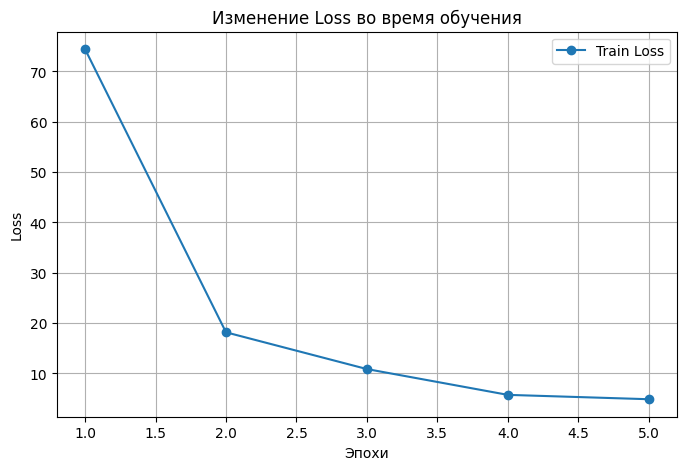

In [6]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.xlabel("Эпохи")
plt.ylabel("Loss")
plt.title("Изменение Loss во время обучения")
plt.legend()
plt.grid()
plt.show()


In [4]:
# Сохранение модели в файл
torch.save({
    'model_state_dict': model.state_dict(),
    'tag2id': tag2id,
    'id2tag': id2tag
}, "bert_crf_model.pth")

print("Модель сохранена в bert_crf_model.pth")


Модель сохранена в bert_crf_model.pth
